In [1]:
from  keras.preprocessing.image  import ImageDataGenerator, img_to_array, load_img 
from  keras.models  import Sequential
from  keras.layers  import Dropout,  Flatten,  Dense
from  keras.applications.vgg16 import VGG16 
from keras.optimizers import RMSprop
from  keras.utils.np_utils import to_categorical 
import time
import os
import numpy as np 
import math
import  matplotlib.pyplot  as  plt

img_width = 224
img_height = 224
batch_size = 64 
epochs = 80
nb_train = 4000
nb_validation = 1200
nb_test = 1200
nb_classes = 4

PATH_TO_FE = "VGG" 
train_dir  =  "balanced_dataset/train"
validation_dir = "balanced_dataset/validation" 
test_dir  =  "balanced_dataset/test" 


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Load Pretrained model
model = VGG16(include_top=False,  weights='imagenet') 

In [3]:
#PREPROCESSING + FEATURE EXTRACTION

datagen  =  ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory( 
    train_dir,
    target_size = (img_width, img_height), 
    batch_size = batch_size,
    class_mode  =  None,  
    shuffle = False, 
    interpolation  =  'lanczos')

validation_generator = datagen.flow_from_directory( 
    validation_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None,
    shuffle=False, 
    interpolation  =  'lanczos')

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle=False, 
    interpolation  =  'lanczos')

###########Feature Extraction (FE)#########################
#Train
max_size_train = int(math.ceil(nb_train / batch_size)) 
train_features = model.predict_generator(train_generator, max_size_train)
np.save('VGG/VGG16_FE_train_1.npy',  train_features)
#Validation
max_size_validation = int(math.ceil(nb_validation / batch_size)) 
validation_features  =  model.predict_generator(validation_generator,  max_size_validation) 
np.save('VGG/VGG16_FE_validation_1.npy',  validation_features)
#Test
max_size_test = int(math.ceil(nb_test / batch_size)) 
test_features  =  model.predict_generator(test_generator,  max_size_test)

#Labels Extraction
train_labels  =  train_generator.classes  
train_labels = to_categorical(train_labels, num_classes=nb_classes) 
validation_labels  =  validation_generator.classes  
validation_labels  =  to_categorical(validation_labels,  num_classes=nb_classes) 
test_labels  =  test_generator.classes  
test_labels  =  to_categorical(test_labels,  num_classes=nb_classes) 

#Save Features
train_data = np.load('VGG/VGG16_FE_train_1.npy') 
validation_data  =  np.load('VGG/VGG16_FE_validation_1.npy')


Found 4000 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [4]:
#Top Model Classificator
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256,  activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(nb_classes,  activation='softmax'))


In [5]:
#Compile models
model.compile(
    optimizer = RMSprop(lr=2e-5),
    loss='categorical_crossentropy',  
    metrics=['accuracy'])


In [6]:
#Train model
history = model.fit(
    train_data, 
    train_labels,
    epochs=epochs,  
    batch_size=batch_size, 
    validation_data=(validation_data, validation_labels))


Train on 4000 samples, validate on 1200 samples
Epoch 1/80
4000/4000 [==============================] - 1s 286us/step - loss: 1.3150 - acc: 0.3855 - val_loss: 1.0832 - val_acc: 0.5617
Epoch 2/80
4000/4000 [==============================] - 1s 156us/step - loss: 1.0629 - acc: 0.5430 - val_loss: 0.9725 - val_acc: 0.6167
Epoch 3/80
4000/4000 [==============================] - 1s 150us/step - loss: 0.9660 - acc: 0.5952 - val_loss: 0.9000 - val_acc: 0.6358
Epoch 4/80
4000/4000 [==============================] - 1s 154us/step - loss: 0.8795 - acc: 0.6530 - val_loss: 0.8499 - val_acc: 0.6492
Epoch 5/80
4000/4000 [==============================] - 1s 156us/step - loss: 0.8285 - acc: 0.6640 - val_loss: 0.7953 - val_acc: 0.6825
Epoch 6/80
4000/4000 [==============================] - 1s 136us/step - loss: 0.7826 - acc: 0.6845 - val_loss: 0.7687 - val_acc: 0.6958
Epoch 7/80
4000/4000 [==============================] - 1s 150us/step - loss: 0.7444 - acc: 0.7043 - val_loss: 0.7424 - val_acc: 0.7150


In [7]:
# h5py 
model.save_weights('VGG/VGG16_FE_model_1.h5')


In [8]:
def print_graphics (history):
    #Mostramos otro tipo de grafico
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+ 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    #plt.tittle('Trainning and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    #plt.tittle('Trainning and validation loss')
    plt.legend()

    plt.show()

In [9]:
def print_evaluate_model(model, history):
    #Evaluate model
    (loss, acc) = model.evaluate(
        test_features, test_labels, 
        batch_size=batch_size, 
        verbose=0)

    print("acc: {0:.2f}% - loss: {1:f}".format(acc * 100, loss))

In [10]:
print_evaluate_model(model, history)

acc: 79.17% - loss: 0.565496


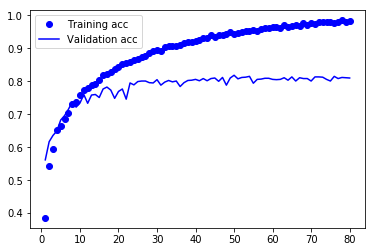

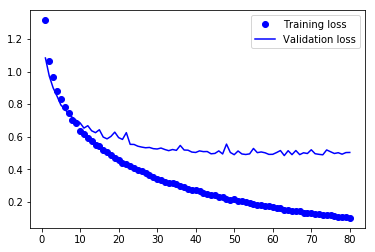

In [11]:
print_graphics (history)